In [1]:
# Load dataset

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
)

In [2]:
# Define model architecture

import torch.nn as nn
class CNN(nn.Module):
    def __init__(self, out_num):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output out_num values
        self.out = nn.Sequential(
            nn.Linear(32 * 7 * 7, out_num),
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [3]:
# Model helper functions

import numpy as np

def generate(model, loaders):

    model.eval()

    # Generate outputs from random model
    total_step = len(loaders['train'])
    with torch.no_grad():
        for i, (images, labels) in enumerate(loaders['train']):
            try:
                output = model(images)
            except:
                output = model(images.unsqueeze(1).float())
            yield output

def create_dataset_labels(outputs_generator):
    outputs_list = []
    for output in outputs_generator:
        outputs_list.append(output)
    outputs_tensor = torch.cat(outputs_list).squeeze()
    return outputs_tensor

In [4]:
# Create mislabeling dataset class

from sklearn.utils.multiclass import unique_labels
from torch.utils.data import Dataset
import copy

class Mislabeling_Dataset(Dataset):
    """
    a Dataset class that contains a Dataset, providing the data of the internal Dataset
    but with labeling errors
    """
    def __init__(self, internal_dataset, internal_dataset_labels = None, fraction_mislabeled = 0.1, random_state = None):

        super().__init__()
        self.internal_dataset = copy.deepcopy(internal_dataset)
        self.true_labels = copy.deepcopy(internal_dataset_labels)
        if self.true_labels is None:
            self.set_true_labels()
        elif len(self.true_labels) != len(internal_dataset):
          raise Exception("Must have same number of labels as the length of the dataset [i.e. len(internal_dataset_labels) == len(internal_dataset)]")
        self.classes = unique_labels(self.true_labels)
        self.fraction_mislabeled = fraction_mislabeled
        self.rng = np.random.default_rng(random_state)
        # could potentially add a parameter to choose what method to mislabel (e.g., completely random, half mislabeled from each class)


        self.mislabel_sample_inds = self.rng.choice(np.arange(len(self.internal_dataset)), \
                                                    size=int(self.fraction_mislabeled*len(internal_dataset)), \
                                                    replace=False)
        mislabel_maps = [[class_j for class_j in self.classes if class_j != class_i] for class_i in self.classes]

        self.labels = copy.deepcopy(self.true_labels)
        for ind in self.mislabel_sample_inds:
            self.labels[ind] = mislabel_maps[self.true_labels[ind]][self.rng.integers(len(self.classes)-1)]


    def set_true_labels(self):
        # helper function used by __init__()
        self.true_labels = np.zeros(len(self.internal_dataset), dtype=object)
        for i in range(len(self.internal_dataset)):
            self.true_labels[i] = self.internal_dataset[i][1]

    def __getitem__(self, idx):
        return self.internal_dataset[idx][0], self.labels[idx].item()

    def __len__(self):
        return len(self.internal_dataset)

In [5]:
# Create mislabled dataset

mislabeled_train_data = Mislabeling_Dataset(train_data, internal_dataset_labels=train_data.targets, \
                                            fraction_mislabeled=0.1, random_state=0)

In [6]:
# Optimizer

from torch import optim

loss_func = nn.CrossEntropyLoss()

In [7]:
# Define training functioning

from torch.autograd import Variable
num_epochs = 1

def train_CNN(num_epochs, cnn, loaders, optimizer):

    cnn.train()

    # Train the model
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

In [71]:
# Useful functions

import matplotlib.pyplot as plt
def calc_std_ratios(clean_df, mislabeled_df, mislabeled_dict, clean_dict):
    ratios_list = []
    ratios_dict = {}
    for n in range(len(clean_dict.keys())):
        ratios_dict[n] = np.std(np.sort(mislabeled_df[n].values) \
                                [:(len(mislabeled_df[n].values) - mislabeled_dict[n])]) / \
                         np.std(np.sort(clean_df[n].values) \
                                [:(len(clean_df[n].values) - clean_dict[n])])
        ratios_list.append(ratios_dict[n])
    return np.mean(ratios_list), ratios_dict

def calc_means(mislabeled_df, mislabeled_dict):
    means_list = []
    means_dict = {}
    for n in range(len(mislabeled_df.columns)):
        means_dict[n] = np.mean(np.sort(mislabeled_df[n].values) \
                                [:(len(mislabeled_df[n].values) - mislabeled_dict[n])])
        means_list.append(means_dict[n])
    return np.mean(means_list), means_dict

def calc_overall_mean(mislabeled_df):
    mislabeled_array = mislabeled_df.to_numpy()
    new_shape = np.prod(mislabeled_array.shape)
    reshaped_array = np.reshape(mislabeled_array, new_shape)
    mean_ = np.mean(np.sort(reshaped_array)[:(len(reshaped_array) - mislabeled_array.shape[0])])
    return mean_

def softmaxed_outputs_array(model, loaders):
    model_outputs = create_dataset_labels(generate(model, loaders))
    m = nn.Softmax(dim=1)
    softmaxed_array = m(model_outputs).numpy()
    return softmaxed_array

def outputs_hist(data_array, model_title, single=False):
    if not single:
        for col in range(data_array.shape[1]):
            plt.figure()
            plt.hist(data_array[:,col], bins=100)
            plt.title("outputs for class {}, {}".format(col, model_title))
            plt.xlabel("value")
            plt.ylabel("counts")
            plt.show()
    else:
        new_shape = np.prod(data_array.shape)
        reshaped_data = np.reshape(data_array, new_shape)
        plt.figure()
        plt.hist(reshaped_data, bins=100)
        plt.title("outputs for all classes, {}".format(model_title))
        plt.xlabel("value")
        plt.ylabel("counts")
        plt.show()

def num_mislabeled_dict(dataset):
    num_samples_dict = {}
    for class_ in range(len(dataset.classes)):
        try:
            num_samples_dict[class_] = sum(dataset.labels.numpy() == class_)
        except:
            num_samples_dict[class_] = sum(dataset.targets.numpy() == class_)
    return num_samples_dict

def calc_ideal_dist(dataset, bins):
    num_ones = len(dataset)
    num_zeros = num_ones * (len(dataset.classes) - 1)
    counts = np.zeros(bins)
    counts[0] = num_zeros
    counts[-1] = num_ones
    return counts

def angular_similarity(vec1, vec2):
    cosine_similarity = np.dot(vec1, vec2) / ( np.linalg.norm(vec1) * np.linalg.norm(vec2) )
    angular_distance = np.arccos(cosine_similarity) / np.pi
    similarity = 1 - angular_distance
    return similarity

In [26]:
# Let's go again with a different percentage and define a function to help out

def mislabeling_statistics(error_percentage, training_dataset, clean_df, clean_dict, epochs, plot=False):
    mislabeled_dataset = Mislabeling_Dataset(training_dataset, internal_dataset_labels=training_dataset.targets, \
                                             fraction_mislabeled=error_percentage, random_state=0)
    model_mislabeled_stats = CNN(len(training_dataset.classes))
    optimizer_mislabeled_stats = optim.Adam(model_mislabeled_stats.parameters(), lr = 0.01)
    loaders_mislabeled_stats = {
    'train' : torch.utils.data.DataLoader(mislabeled_dataset,
                                          batch_size=100,
                                          shuffle=False,
                                          num_workers=0),

    'test' : torch.utils.data.DataLoader(training_dataset,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=0),
    }
    print("training {}% mislabeled model".format(error_percentage*100))
    train_CNN(epochs, model_mislabeled_stats, loaders_mislabeled_stats, optimizer_mislabeled_stats)
    outputs_mislabeled_stats = softmaxed_outputs_array(model_mislabeled_stats, loaders_mislabeled_stats)
    if plot:
        outputs_hist(outputs_mislabeled_stats, "{}% mislabeled model".format(error_percentage*100), single=True)
    mislabeled_stats_df = pd.DataFrame(outputs_mislabeled_stats)
    mislabeled_stats_dict = num_mislabeled_dict(mislabeled_dataset)
    mean_std_out, std_dict_out = calc_std_ratios(clean_df, mislabeled_stats_df, mislabeled_stats_dict, clean_dict)
    mean_out, mean_dict_out = calc_means(mislabeled_stats_df, mislabeled_stats_dict)
    overall_mean = calc_overall_mean(mislabeled_stats_df)
    print(overall_mean, "\n")
    del model_mislabeled_stats
    return mean_out, mean_dict_out, mean_std_out, std_dict_out, overall_mean

In [72]:
# Let's do something with cosine similarity of the distributions now

def mislabeling_dist_similarity(error_percentage, training_dataset, epochs, num_bins, plot=False):
    mislabeled_dataset = Mislabeling_Dataset(training_dataset, internal_dataset_labels=training_dataset.targets, \
                                             fraction_mislabeled=error_percentage, random_state=0)
    model_mislabeled_stats = CNN(len(training_dataset.classes)).to(device)
    optimizer_mislabeled_stats = optim.Adam(model_mislabeled_stats.parameters(), lr = 0.01)
    loaders_mislabeled_stats = {
    'train' : torch.utils.data.DataLoader(mislabeled_dataset,
                                          batch_size=100,
                                          shuffle=False,
                                          num_workers=0),

    'test' : torch.utils.data.DataLoader(training_dataset,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=0),
    }
    print("training {}% mislabeled model".format(error_percentage*100))
    train_CNN(epochs, model_mislabeled_stats, loaders_mislabeled_stats, optimizer_mislabeled_stats)
    outputs_mislabeled_stats = softmaxed_outputs_array(model_mislabeled_stats, loaders_mislabeled_stats)
    if plot:
        outputs_hist(outputs_mislabeled_stats, "{}% mislabeled model".format(error_percentage*100), single=True)
    outputs_mislabeled_vector = np.reshape(outputs_mislabeled_stats, np.prod(outputs_mislabeled_stats.shape))
    counts, bins = np.histogram(outputs_mislabeled_vector, bins=num_bins)
    ideal_counts = calc_ideal_dist(training_dataset, bins=num_bins)
    
    # Calculate similarity between sample distribution and ideal distribution
    similarity = angular_similarity(counts, ideal_counts)
    
    del model_mislabeled_stats
    print("Similarity to Ideal:", similarity, "\n")
    
    return similarity

In [75]:
# Let's try a bunch of different error percentages

def error_percentage_looper(bound1, bound2, plot=True):
    error_percent_list = []
    similarity_list = []
    
    for n in range(bound1, bound2+1):
        if plot:
            similarity = mislabeling_dist_similarity(n/100, train_data, epochs=1, plot=True, num_bins=100)
        else:
            similarity = mislabeling_dist_similarity(n/100, train_data, epochs=1, plot=False, num_bins=100)
        error_percent_list.append(n/100)
        similarity_list.append(similarity)
    return error_percent_list, similarity_list

In [76]:
def multi_looper(bound1, bound2, num_trials, plot=True):
    trials_dict = {}
    for n in range(num_trials):
        if plot:
            list_1, list_2 = error_percentage_looper(bound1, bound2)
        else:
            list_1, list_2 = error_percentage_looper(bound1, bound2, plot=False)
        data_array = np.array([list_1, list_2]).transpose()
        trials_dict["trial {}".format((n+1))] = data_array
    return trials_dict

training 0.0% mislabeled model
Epoch [1/1], Step [100/600], Loss: 0.0786
Epoch [1/1], Step [200/600], Loss: 0.0719
Epoch [1/1], Step [300/600], Loss: 0.1045
Epoch [1/1], Step [400/600], Loss: 0.0385
Epoch [1/1], Step [500/600], Loss: 0.1360
Epoch [1/1], Step [600/600], Loss: 0.3120


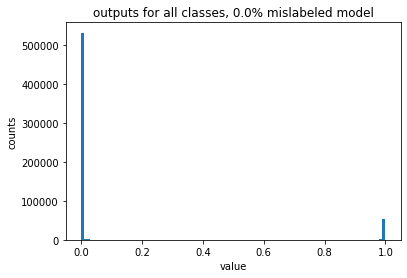

Similarity to Ideal: 0.9963771143067462 

training 1.0% mislabeled model
Epoch [1/1], Step [100/600], Loss: 0.1236
Epoch [1/1], Step [200/600], Loss: 0.0928
Epoch [1/1], Step [300/600], Loss: 0.4106
Epoch [1/1], Step [400/600], Loss: 0.3772
Epoch [1/1], Step [500/600], Loss: 0.3626
Epoch [1/1], Step [600/600], Loss: 0.3168


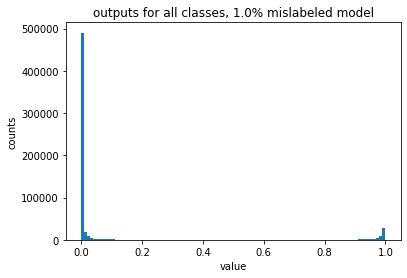

Similarity to Ideal: 0.9760647805632997 

training 2.0% mislabeled model
Epoch [1/1], Step [100/600], Loss: 0.3988
Epoch [1/1], Step [200/600], Loss: 0.1618
Epoch [1/1], Step [300/600], Loss: 0.2945
Epoch [1/1], Step [400/600], Loss: 0.2315
Epoch [1/1], Step [500/600], Loss: 0.2366
Epoch [1/1], Step [600/600], Loss: 0.2517


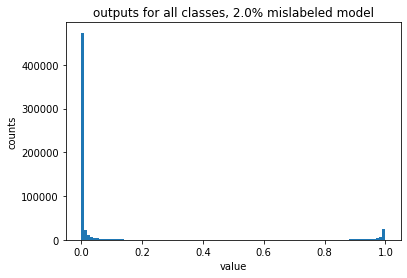

Similarity to Ideal: 0.9731228783095097 

training 3.0% mislabeled model
Epoch [1/1], Step [100/600], Loss: 0.3184
Epoch [1/1], Step [200/600], Loss: 0.1965
Epoch [1/1], Step [300/600], Loss: 0.8456
Epoch [1/1], Step [400/600], Loss: 0.3188
Epoch [1/1], Step [500/600], Loss: 0.4985
Epoch [1/1], Step [600/600], Loss: 0.3009


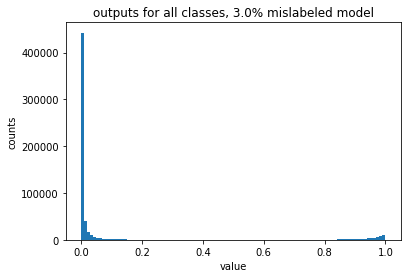

Similarity to Ideal: 0.9559098259975606 

training 4.0% mislabeled model
Epoch [1/1], Step [100/600], Loss: 0.3891
Epoch [1/1], Step [200/600], Loss: 0.4045
Epoch [1/1], Step [300/600], Loss: 0.9055
Epoch [1/1], Step [400/600], Loss: 0.3312
Epoch [1/1], Step [500/600], Loss: 0.5060
Epoch [1/1], Step [600/600], Loss: 0.3960


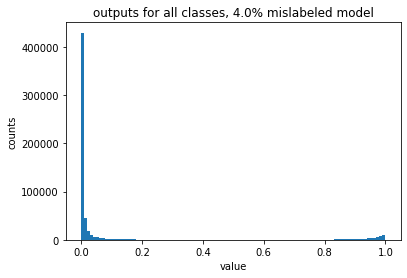

Similarity to Ideal: 0.9522693214865771 

training 5.0% mislabeled model
Epoch [1/1], Step [100/600], Loss: 0.3514
Epoch [1/1], Step [200/600], Loss: 0.6231
Epoch [1/1], Step [300/600], Loss: 0.8271
Epoch [1/1], Step [400/600], Loss: 0.3320
Epoch [1/1], Step [500/600], Loss: 0.6305
Epoch [1/1], Step [600/600], Loss: 0.5109


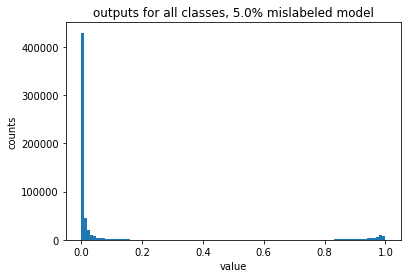

Similarity to Ideal: 0.9510091342460737 

training 6.0% mislabeled model
Epoch [1/1], Step [100/600], Loss: 0.5173
Epoch [1/1], Step [200/600], Loss: 0.6276
Epoch [1/1], Step [300/600], Loss: 0.9936
Epoch [1/1], Step [400/600], Loss: 0.3708
Epoch [1/1], Step [500/600], Loss: 0.5653


In [ ]:
plot = True
bound1 = 0
bound2 = 40
num_trials = 25
trials_dict = {}

for n in range(num_trials):
    if plot:
        list_1, list_2 = error_percentage_looper(bound1, bound2)
    else:
        list_1, list_2 = error_percentage_looper(bound1, bound2, plot=False)
    data_array = np.array([list_1, list_2]).transpose()
    trials_dict["trial {}".format((n+1))] = data_array

In [49]:
remove_list = [22, 23, 27, 29, 32, 34]

list_1_copy = np.delete(list_1, remove_list)
list_2_copy = np.delete(list_2, remove_list)

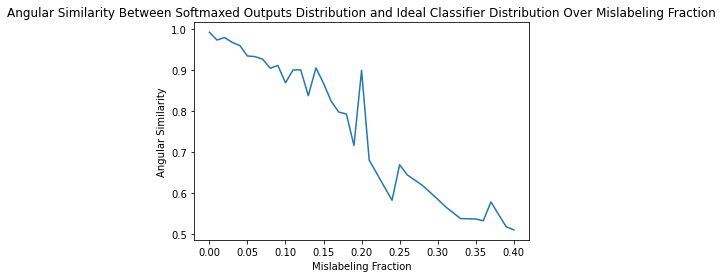

In [54]:
plt.figure()
plt.plot(list_1_copy, list_2_copy)
plt.title("Angular Similarity Between Softmaxed Outputs Distribution and Ideal Classifier Distribution Over \
Mislabeling Fraction")
plt.xlabel("Mislabeling Fraction")
plt.ylabel("Angular Similarity")
plt.show()